In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy.linalg
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import torch
from time import time

In [2]:
# LE FUNÇÃO QUE GERA O DATAFRAME COM OS GRAFOS
def generate_graphs(num_nodes, qtd, k):
    data = {'Erdos_Renyi_Graph': [],'Matrix_L': [],'Matrix_A': [], 'p': [], 'Eigenvalues_L': [], 'Eigenvalues_A': []}
    
    for j in range(k+1):
        start = time()
        for i in range(qtd):
            p = random.random() # Adjust this range as per your requirement
            
            G = nx.erdos_renyi_graph(num_nodes, p)
            A = nx.laplacian_matrix(G).todense()
            A2 = nx.adjacency_matrix(G).todense()
            laplacian_eigenvalues = np.linalg.eigvalsh(A)
            e = numpy.linalg.eigvalsh(A2)
            sorted_laplacian_eigenvalues = sorted(laplacian_eigenvalues)
            sorted_e = sorted(e)
            data['Erdos_Renyi_Graph'].append(G)
            data['Matrix_L'].append(A)
            data['Matrix_A'].append(A2)
            data['p'].append(p)
            data['Eigenvalues_L'].append(sorted_laplacian_eigenvalues)
            data['Eigenvalues_A'].append(sorted_e)
        print(f'para num_nodes = {num_nodes} demorou {time() - start}')
        num_nodes += 10
    
    df = pd.DataFrame(data)
    return df


# LE FUNÇÃO zero_pad_adjacency_matrices
def zero_pad_adjacency_matrices(column):
    # Find the maximum number of nodes in the adjacency matrices
    max_nodes = max(len(matrix) for matrix in column)
    
    # Zero-pad the adjacency matrices to have the same number of nodes
    zero_padded_matrices = []
    for matrix in column:
        padded_matrix = np.pad(matrix, ((0, max_nodes - len(matrix)), (0, max_nodes - len(matrix))), mode='constant')
        zero_padded_matrices.append(padded_matrix)
    
    return zero_padded_matrices


# LE FUNÇÃO remove_zero_padding
def remove_zero_padding(adjacency_matrix):
    # Check if the adjacency matrix is empty
    if adjacency_matrix.numel() == 0:
        return adjacency_matrix
    
    # Check if the adjacency matrix is zero-padded
    if torch.sum(adjacency_matrix[:, -1]) == 0 and torch.sum(adjacency_matrix[-1, :]) == 0:
        # Find the indices of the last row and column that are not zero
        try:
            last_row_index = torch.nonzero(adjacency_matrix.sum(dim=1)).max()
        except:
            print("AAAAAAAAAAAAAAAAA\n")
            num_zeros = torch.sum(adjacency_matrix == 0.).item()
            num_ones = torch.sum(adjacency_matrix == 1.).item()
            print(f'num_ones: {num_ones} num_zeros: {num_zeros} | shape: {adjacency_matrix.shape}')
            print_full(adjacency_matrix)
            return
        last_col_index = torch.nonzero(adjacency_matrix.sum(dim=0)).max()

        # Extract the non-padded version of the adjacency matrix
        non_padded_matrix = adjacency_matrix[: last_row_index.item() + 1, : last_col_index.item() + 1]

        return non_padded_matrix
    else:
        # If the adjacency matrix is not zero-padded, return the original tensor
        return adjacency_matrix


def print_full(matrix):
    try:
        matrix = matrix.detach().numpy()
    except:
        pass
    # Print the matrix
    for row in matrix:
        formatted_row = ["{:.1f}".format(float(element)) for element in row]
        print(" ".join(formatted_row))


# FUNÇÃO QUE TRANSFORMA MATRIX DE ADJACENCIA EM TENSOR DA TRIANGULAR INFERIOR NO DATAFRAME
import torch
import pandas as pd

def lower_triangular_only_from_dataframe(df_column):
    # Get the number of matrices
    num_matrices = len(df_column)

    # Get the size of the matrix from the first element
    matrix_size = len(df_column.iloc[0])

    # Calculate the number of elements in the lower triangular part (excluding the diagonal)
    num_elements_lower_triangular = (matrix_size * (matrix_size - 1)) // 2

    # Create an empty list to store the lower triangular tensors
    lower_triangular_tensors_list = []

    # Iterate over each matrix
    for i in range(num_matrices):
        # Flatten the lower triangular part of the matrix (excluding the diagonal)
        lower_triangular_tensor = torch.tensor(df_column.iloc[i], dtype=torch.float).tril(diagonal=-1)[torch.tril(torch.ones(matrix_size, matrix_size, dtype=torch.float), diagonal=-1).bool()].flatten()

        lower_triangular_tensors_list.append(lower_triangular_tensor)

    # Create a new column with the lower triangular tensors
    #lower_triangular_column = torch.tensor(lower_triangular_tensors_list)

    #return lower_triangular_column
    return lower_triangular_tensors_list

In [3]:
import torch
import pandas as pd

def lower_triangular_only_from_dataframe(df_column):
    # Create an empty list to store the lower triangular elements
    lower_triangular_elements_list = []

    # Iterate over each matrix in the DataFrame column
    for matrix in df_column:
        # Convert the matrix to a PyTorch tensor
        matrix_tensor = torch.tensor(matrix, dtype=torch.float)
        
        # Get the indices for the lower triangular part of the matrix (excluding the diagonal)
        row_indices, col_indices = torch.tril_indices(matrix_tensor.size(0), matrix_tensor.size(1), offset=-1)
        
        # Extract the lower triangular elements using the indices
        lower_triangular_elements = matrix_tensor[row_indices, col_indices]
        
        # Convert the elements to a list and append to the result list
        lower_triangular_elements_list.append(lower_triangular_elements.tolist())

    # Convert the list of lists to a PyTorch tensor
    lower_triangular_tensor = torch.tensor(lower_triangular_elements_list, dtype=torch.float)

    return lower_triangular_tensor

In [3]:
# GERA O DATAFRAME COM OS GRAFOS
min_num_nodes = 60
qtd = 1000
k = 4
max_num_nodes = min_num_nodes + (10*k)
print(max_num_nodes)
df = generate_graphs(min_num_nodes, qtd, k)
df = df.iloc[:-1]
#print(df)

100
para num_nodes = 60 demorou 2.544306516647339
para num_nodes = 70 demorou 3.581444501876831
para num_nodes = 80 demorou 4.597017526626587
para num_nodes = 90 demorou 6.47362494468689
para num_nodes = 100 demorou 8.512059926986694


In [5]:
print(len(df))
# Drop rows where Matrix_A has all elements equal to zero
df = df[~df['Matrix_A'].apply(lambda x: np.all(x == 0.))]
print(len(df))

# Check for matrices with all elements equal to zero
zero_matrices = df[df['Matrix_A'].apply(lambda x: np.all(x == 0))]

# If there are any, print their entire rows
if not zero_matrices.empty:
    print("Matrices with all elements equal to zero:")
    print(zero_matrices)
else:
    print("No matrices with all elements equal to zero found.")

4995
4995
No matrices with all elements equal to zero found.


In [ ]:
#GERA COLUNAS DE MATRIZES ZERO-PAD NO DATAFRAME

padded_Matrix_A = zero_pad_adjacency_matrices(df['Matrix_A'])
df['padded_Matrix_A'] = padded_Matrix_A

#GERA COLUNA DE TENSOR DA TRIANGULAR INFERIOR DA MATRIZ ZERO-PAD NO DATAFRAME
lower_triangular_1 = lower_triangular_only_from_dataframe(df['padded_Matrix_A'])
#df['lower_triangular'] = lower_triangular

In [ ]:
type(lower_triangular_1[0])

In [ ]:
for i in range(len(lower_triangular_1)):
    print(torch.equal(lower_triangular_1[0], lower_triangular_1[i]))

In [17]:
(torch.sum(lower_triangular_1[1]))

tensor(44.)

In [4]:
#carrega base
df = pd.read_pickle('base_5k_60n_100n.pkl')

In [9]:
len(df)

4995

In [11]:
#carrega base 2
df2 = pd.read_pickle('base_varios_tipos_60n_100n.pkl')

In [13]:
len(df2)

5978

In [14]:
df.columns

Index(['Erdos_Renyi_Graph', 'Matrix_L', 'Matrix_A', 'p', 'Eigenvalues_L',
       'Eigenvalues_A', 'padded_Matrix_A', 'padded_Matrix_L'],
      dtype='object')

In [25]:
df['Tipo'] = "01. Erdos-Renyi"

# Function to get the number of nodes
def get_number_of_nodes(matrix):
    return len(matrix)

# Create the 'Qtd_nodes' column
df['Qtd_Nodes'] = df.iloc[:, 1].apply(get_number_of_nodes)
df.rename(columns={'Erdos_Renyi_Graph': 'Graph'}, inplace=True)
df.rename(columns={'p': 'param_1'}, inplace=True)
df['param_2'] = np.nan
df.rename(columns={'Eigenvalues_A': 'Eigenvalues'}, inplace=True)
print(df.columns)

Index(['Graph', 'Matrix_L', 'Matrix_A', 'param_1', 'Eigenvalues_L',
       'Eigenvalues', 'padded_Matrix_A', 'padded_Matrix_L', 'Qtd_nodes',
       'Tipo', 'param_2', 'Qtd_Nodes'],
      dtype='object')


In [27]:
columns_to_keep = ['Tipo', 'Qtd_Nodes', 'Graph', 'Matrix_A', 'param_1', 'param_2',
       'Eigenvalues', 'padded_Matrix_A']
df_aux = df[columns_to_keep]
print(df_aux.columns)

Index(['Tipo', 'Qtd_Nodes', 'Graph', 'Matrix_A', 'param_1', 'param_2',
       'Eigenvalues', 'padded_Matrix_A'],
      dtype='object')


In [28]:
df2.columns

Index(['Tipo', 'Qtd_Nodes', 'Graph', 'Matrix_A', 'param_1', 'param_2',
       'Eigenvalues', 'padded_Matrix_A'],
      dtype='object')

In [32]:
df3 = pd.concat((df_aux,df2),ignore_index=True)

In [33]:
df3

,Tipo,Qtd_Nodes,Graph,Matrix_A,param_1,param_2,Eigenvalues,padded_Matrix_A
0,01. Erdos-Renyi,60,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.093773,NaN,"[-4.356424571704738, -4.312424913153814, -3.90...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,01. Erdos-Renyi,60,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.020015,NaN,"[-2.7607221385465253, -2.4758267932135345, -2....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,01. Erdos-Renyi,60,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,...",0.182010,NaN,"[-5.607410067136412, -5.127320663616507, -5.05...","[[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,..."
3,01. Erdos-Renyi,60,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.024900,NaN,"[-2.65730605544426, -2.2811004739144276, -2.07...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,01. Erdos-Renyi,60,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...",0.236875,NaN,"[-6.095950088406403, -5.874808623816227, -5.44...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,..."
...,...,...,...,...,...,...,...,...
10968,12. Complete,100,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN,"[-1.0000000000000118, -1.000000000000002, -1.0...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
10969,12. Complete,100,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN,"[-1.0000000000000118, -1.000000000000002, -1.0...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
10970,12. Complete,100,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN,"[-1.0000000000000118, -1.000000000000002, -1.0...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
10971,12. Complete,100,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",NaN,NaN,"[-1.0000000000000118, -1.000000000000002, -1.0...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [34]:
#GERA COLUNAS DE MATRIZES ZERO-PAD NO DATAFRAME

padded_Matrix_A = zero_pad_adjacency_matrices(df3['Matrix_A'])
df3['padded_Matrix_A'] = padded_Matrix_A

#GERA COLUNA DE TENSOR DA TRIANGULAR INFERIOR DA MATRIZ ZERO-PAD NO DATAFRAME
lower_triangular_1 = lower_triangular_only_from_dataframe(df3['padded_Matrix_A'])
#df['lower_triangular'] = lower_triangular

In [144]:
import torch.nn as nn
import statistics
from scipy.stats import wasserstein_distance

class CustomEMDLoss(nn.Module):
    def __init__(self, bandwidth=1.0):
        super(CustomEMDLoss, self).__init__()

    def forward(self, original_tensors, layer_tensor):
        total_error = 0
        maior_erro = 0 
        menor_erro = 100
        original_matrices = from_one_dimension_representation(original_tensors)
        
        num_layers = len(layer_tensor)
        layer_matrices_list = []
        
        for i in range(num_layers):
            matrizes_layer = from_one_dimension_representation(layer_tensor[i])
            layer_matrices_list.append(matrizes_layer)
        '''            
        controle_erro_deciles = []
        controle_erro_quarters = []
        controle_erro_mean = []
        controle_erro_median = []
        controle_erro_max = []
        controle_erro_min = []
        controle_erro_gap = []
        controle_erro_segundo = []
        controle_erro_pp_zero = []
        '''
        Trava = False
        controle_erro_EMD = []

        erros_por_layer = [[] for _ in range(8)]
          
        for idx, adjacency_matrix in enumerate(original_matrices):
            A = remove_zero_padding(adjacency_matrix)
            try:original_eigenvalues2 = torch.linalg.eigvalsh(A)
            except: original_eigenvalues2 = torch.linalg.eigvalsh(adjacency_matrix)
            # Ordenando os autovalores em ordem crescente
            original_eigenvalues, _ = torch.sort(original_eigenvalues2)
            '''
            mean_A = torch.mean(original_eigenvalues)
            median_A = torch.median(original_eigenvalues)
            max_A = torch.max(original_eigenvalues)
            min_A = torch.min(original_eigenvalues)
            quarters_A = count_eigenvalues_per_quarter(original_eigenvalues)
            deciles_A = count_eigenvalues_per_decile(original_eigenvalues)
            gap_A = original_eigenvalues[-1] - original_eigenvalues[-2]
            segundo_menor_A = original_eigenvalues[1]
            percent_zero_A = torch.tensor(percent_zero_eigenvalues(original_eigenvalues))
            '''
            all_layers_graph_error = 0
            layer_count = 1
            for layer_matrices in layer_matrices_list:
                layer_matrix = layer_matrices[idx]
                if torch.all(layer_matrix == 0.):
                    print(f"idx: {idx} | Layer: {layer_count} Matriz veio toda zerada")
                    layer_eigenvalues2 = torch.rand((layer_matrix.size(0))*100, device='cpu')
                else:
                    B = remove_zero_padding(layer_matrix)
                    try:
                        layer_eigenvalues2 = torch.linalg.eigvalsh(B)
                        if torch.isnan(layer_eigenvalues2).any(): 
                            print(f"idx: {idx} | Layer: {layer_count} eigvalsh veio nan, pulando...")
                            continue
                    except: 
                        print(f"idx: {idx} | Layer: {layer_count} Matriz falhou no eigvalsh, tentando com eigvals...")
                        layer_eigenvalues2_aux = torch.linalg.eigvals(B)
                        layer_eigenvalues2 = layer_eigenvalues2_aux.real
                        if torch.isnan(layer_eigenvalues2).any(): 
                            print(f"idx: {idx} | Layer: {layer_count} eigvals veio nan, pulando...")
                            continue
                layer_eigenvalues, _ = torch.sort(layer_eigenvalues2)
                
                erro_EMD = _cdf_distance(1,original_eigenvalues, layer_eigenvalues)+1
                if torch.isnan(erro_EMD):
                    print("The tensor contains NaN values.")
                    print('Entrei aqui vish')
                    print(f'original_eigenvalues {original_eigenvalues.device} layer_eigenvalues {layer_eigenvalues.device}')
                    print(f'original_eigenvalues {original_eigenvalues.shape} layer_eigenvalues {layer_eigenvalues.shape}')
                    print(f'original_eigenvalues {original_eigenvalues} layer_eigenvalues {layer_eigenvalues}')
                    erro_EMD = 10.
                        
                erros_por_layer[layer_count-1].append(erro_EMD.item())

                controle_erro_EMD.append(erro_EMD.item())
                all_layers_graph_error += (erro_EMD**2)


                layer_count += 1

            total_error += all_layers_graph_error

            if all_layers_graph_error > maior_erro:
                maior_erro = all_layers_graph_error
            if all_layers_graph_error < menor_erro:
                menor_erro = all_layers_graph_error
                
        #print()
        #print(f'erro_deciles  - Max: {np.max(controle_erro_deciles):.1f}  | Mean: {np.mean(controle_erro_deciles):.1f}  | Min: {np.min(controle_erro_deciles):.1f}  ')
        #print(f'erro_layer_1  - Max: {np.max(erros_por_layer[0]):.1f} | Mean: {np.mean(erros_por_layer[0]):.1f}  | Min: {np.min(erros_por_layer[0]):.1f} ')
        #print(f'erro_layer_2  - Max: {np.max(erros_por_layer[1]):.1f} | Mean: {np.mean(erros_por_layer[1]):.1f}  | Min: {np.min(erros_por_layer[1]):.1f}     ')
        #print(f'erro_layer_3  - Max: {np.max(erros_por_layer[2]):.1f} | Mean: {np.mean(erros_por_layer[2]):.1f}  | Min: {np.min(erros_por_layer[2]):.1f}   ')
        #print(f'erro_layer_4  - Max: {np.max(erros_por_layer[3]):.1f} | Mean: {np.mean(erros_por_layer[3]):.1f}  | Min: {np.min(erros_por_layer[3]):.1f}      ')
        #print(f'erro_layer_5  - Max: {np.max(erros_por_layer[4]):.1f} | Mean: {np.mean(erros_por_layer[4]):.1f}  | Min: {np.min(erros_por_layer[4]):.1f}      ')
        #print(f'erro_layer_6  - Max: {np.max(erros_por_layer[5]):.1f} | Mean: {np.mean(erros_por_layer[5]):.1f}  | Min: {np.min(erros_por_layer[5]):.1f}      ')
        #print(f'erro_layer_7  - Max: {np.max(erros_por_layer[6]):.1f} | Mean: {np.mean(erros_por_layer[6]):.1f}  | Min: {np.min(erros_por_layer[6]):.1f}  ')
        #print(f'erro_layer_8  - Max: {np.max(erros_por_layer[7]):.1f} | Mean: {np.mean(erros_por_layer[7]):.1f}  | Min: {np.min(erros_por_layer[7]):.1f}  ')
        #print(f'erro_ks       - Max: {np.max(controle_erro_ks):.1f}  | Mean: {np.mean(controle_erro_ks):.1f}  | Min: {np.min(controle_erro_ks):.1f}  ')

        average_loss = total_error / (len(original_tensors) * num_layers)
        return average_loss
'''
                mean_B = torch.mean(layer_eigenvalues)
                median_B = torch.median(layer_eigenvalues)
                max_B = torch.max(layer_eigenvalues)
                min_B = torch.min(layer_eigenvalues)
                quarters_B = count_eigenvalues_per_quarter(layer_eigenvalues)
                deciles_B = count_eigenvalues_per_decile(layer_eigenvalues)
                gap_B = layer_eigenvalues[-1] - layer_eigenvalues[-2]
                segundo_menor_B = layer_eigenvalues[1]
                percent_zero_B = torch.tensor(percent_zero_eigenvalues(layer_eigenvalues))
                
                erro_deciles = (torch.sum(torch.abs(deciles_A - deciles_B))) * 10
                erro_quarters = (torch.sum(torch.abs(quarters_A - quarters_B))) * 10
                erro_mean = torch.abs(mean_A - mean_B)
                erro_median = torch.abs(median_A - median_B)
                erro_max = torch.abs(max_A - max_B)
                erro_min = torch.abs(min_A - min_B)
                erro_gap = torch.abs(gap_A - gap_B)
                erro_segundo = torch.abs(segundo_menor_A - segundo_menor_B)
                erro_percent_zero = torch.abs(percent_zero_A - percent_zero_B)

                controle_erro_deciles.append(erro_deciles.item())
                controle_erro_quarters.append(erro_quarters.item())
                controle_erro_mean.append(erro_mean.item())
                controle_erro_median.append(erro_median.item())
                controle_erro_max.append(erro_max.item())
                controle_erro_min.append(erro_min.item())
                controle_erro_gap.append(erro_gap.item())
                controle_erro_segundo.append(erro_segundo.item())
                controle_erro_pp_zero.append(erro_percent_zero.item())

                if idx == 0: 
                    lista = [erro_deciles.item(), erro_quarters.item(), erro_mean.item(), erro_median.item(), erro_max.item(), erro_min.item(),\
                            erro_EMD.item()]
                    print(f'layer: {layer_count} | erro {erro_EMD}')
                    plot_graphs_side_by_side(A,B,idx)
                    plot_eigenvalue_histograms(original_eigenvalues,layer_eigenvalues,idx, erro_do_grafo, lista)
'''                

def _cdf_distance(p, u_values, v_values, u_weights=None, v_weights=None):
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance : float
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """
    u_sorter = torch.argsort(u_values)
    v_sorter = torch.argsort(v_values)

    all_values = torch.concatenate((u_values, v_values))
    all_values, _ = torch.sort(all_values)

    # Compute the differences between pairs of successive values of u and v.
    deltas = torch.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = torch.searchsorted(u_values[u_sorter], all_values[:-1], right=True)
    v_cdf_indices = torch.searchsorted(v_values[v_sorter], all_values[:-1], right=True)

    # Calculate CDFs using weights if provided
    if u_weights is None:
        u_cdf = u_cdf_indices.float() / u_values.size(0)
    else:
        u_sorted_cumweights = torch.cat((torch.tensor([0.0]), torch.cumsum(u_weights[u_sorter], dim=0)))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices.float() / v_values.size(0)
    else:
        v_sorted_cumweights = torch.cat((torch.tensor([0.0]), torch.cumsum(v_weights[v_sorter], dim=0)))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    # Compute the integral of the absolute differences of CDFs raised to the power p
    cdf_diff = torch.abs(u_cdf - v_cdf)
    
    if p == 1:
        return torch.sum(cdf_diff * deltas)
    if p == 2:
        return torch.sqrt(torch.sum(cdf_diff ** 2 * deltas))
    return torch.sum(cdf_diff ** p * deltas) ** (1 / p)
   
import matplotlib.pyplot as plt
import networkx as nx

def plot_eigenvalue_histograms(eigenvalues1, eigenvalues2, index, loss_value, error_metrics):
    # Convert tensors to numpy arrays if necessary
    if isinstance(eigenvalues1, torch.Tensor):
        eigenvalues1 = eigenvalues1.detach().numpy()
    if isinstance(eigenvalues2, torch.Tensor):
        eigenvalues2 = eigenvalues2.detach().numpy()

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Increased height for error metrics

    # Plot the histogram for the first set of eigenvalues
    ax = axes[0]
    ax.hist(eigenvalues1, bins=10, color='lightblue', edgecolor='black')
    ax.set_title(f'Eigenvalue Histogram 1 (Index {index})')
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Frequency')

    # Plot the histogram for the second set of eigenvalues
    ax = axes[1]
    ax.hist(eigenvalues2, bins=10, color='lightgreen', edgecolor='black')
    ax.set_title(f'Eigenvalue Histogram 2 (Index {index})')
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Frequency')

    # Add a super title to display the loss value
    fig.suptitle(f'Loss Value: {loss_value}', fontsize=16)

    # Formatting error metrics
    formatted_errors = [f"{name}: {value:.1f}" for name, value in zip(
        ["Deciles", "Quarters", "Mean", "Median", "Max", "Min", "Gap", "Segundo", "Percent Zero"], 
        error_metrics
    )]
    # Display the error metrics below the histograms
    error_text = " | ".join(formatted_errors)
    fig.text(0.5, 0.01, error_text, ha='center', fontsize=12, wrap=True)

    # Show the plot
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Adjust layout to make room for the super title and error text
    plt.show()

def plot_graphs_side_by_side(adj_matrix1, adj_matrix2, index):
    # Convert tensors to numpy arrays if necessary
    if isinstance(adj_matrix1, torch.Tensor):
        adj_matrix1 = adj_matrix1.detach().numpy()
    if isinstance(adj_matrix2, torch.Tensor):
        adj_matrix2 = adj_matrix2.detach().numpy()

    # Create NetworkX graphs from the adjacency matrices
    G1 = nx.from_numpy_array(adj_matrix1)
    G2 = nx.from_numpy_array(adj_matrix2)

    # Calculate properties for the first graph
    num_nodes1 = G1.number_of_nodes()
    num_edges1 = G1.number_of_edges()
    density1 = nx.density(G1)
    clustering_coefficient1 = nx.average_clustering(G1)
    diameter1 = nx.diameter(G1) if nx.is_connected(G1) else float('inf')
    properties1 = (
        f"Nodes: {num_nodes1}\n"
        f"Edges: {num_edges1}\n"
        f"Density: {density1:.2f}\n"
        f"Avg. Clustering Coeff: {clustering_coefficient1:.2f}\n"
        f"Diameter: {diameter1}"
    )

    # Calculate properties for the second graph
    num_nodes2 = G2.number_of_nodes()
    num_edges2 = G2.number_of_edges()
    density2 = nx.density(G2)
    clustering_coefficient2 = nx.average_clustering(G2)
    diameter2 = nx.diameter(G2) if nx.is_connected(G2) else float('inf')
    properties2 = (
        f"Nodes: {num_nodes2}\n"
        f"Edges: {num_edges2}\n"
        f"Density: {density2:.2f}\n"
        f"Avg. Clustering Coeff: {clustering_coefficient2:.2f}\n"
        f"Diameter: {diameter2}"
    )

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first graph
    ax = axes[0]
    nx.draw(G1, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    ax.text(0.05, 0.95, properties1, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_title(f'Input Graph (Index {index})')

    # Plot the second graph
    ax = axes[1]
    nx.draw(G2, ax=ax, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500, font_size=10)
    ax.text(0.05, 0.95, properties2, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_title(f'Output Graph (Index {index})')



    # Adjust layout
    plt.tight_layout()
    plt.show()

def percent_zero_eigenvalues(eigenvalues):
    """
    Calcula o percentual de autovalores igual a zero em um tensor de autovalores.

    Argumentos:
    eigenvalues: torch.Tensor, tensor de autovalores.

    Retorna:
    percent_zero: float, o percentual de autovalores igual a zero.
    """
    # Conta o número de autovalores igual a zero
    num_zero_eigenvalues = torch.sum(torch.isclose(eigenvalues, torch.tensor(0.)))

    # Calcula o percentual de autovalores igual a zero
    percent_zero = (num_zero_eigenvalues / eigenvalues.numel()) * 100.0
    
    return percent_zero.item()  # Retorna o valor como float


def count_eigenvalues_per_quarter(eigenvalues):
    # Sort the tensor
    sorted_eigenvalues, _ = torch.sort(eigenvalues)

    # Calculate the distance between the maximum and minimum values
    distance = sorted_eigenvalues[-1] - sorted_eigenvalues[0]

    # Divide the distance into quarters
    quarter_distance = distance / 4

    # Initialize counters for each quarter
    quarters_list = [0,0,0,0]
    
    # Iterate through sorted eigenvalues and count which quarter they fall into
    for eigenvalue in sorted_eigenvalues:
        if eigenvalue <= sorted_eigenvalues[0] + quarter_distance:
            quarters_list[0] += 1
        elif eigenvalue <= sorted_eigenvalues[0] + 2 * quarter_distance:
            quarters_list[1] += 1
        elif eigenvalue <= sorted_eigenvalues[0] + 3 * quarter_distance:
            quarters_list[2] += 1
        else:
            quarters_list[3] += 1

    # Calculate fraction of elements in each quarter
    total_elements = len(sorted_eigenvalues)
    quarters_tensor = torch.tensor(quarters_list, dtype=torch.float, requires_grad=True)
    
    fractions = quarters_tensor / total_elements
    return fractions


def count_eigenvalues_per_decile(eigenvalues):
    # Sort the tensor
    sorted_eigenvalues, _ = torch.sort(eigenvalues)

    # Calculate the distance between the maximum and minimum values
    distance = sorted_eigenvalues[-1] - sorted_eigenvalues[0]

    # Divide the distance into deciles
    decile_distance = distance / 10

    # Initialize counters for each decile
    deciles_list = [0] * 10
    
    # Iterate through sorted eigenvalues and count which decile they fall into
    for eigenvalue in sorted_eigenvalues:
        for i in range(10):
            if eigenvalue <= sorted_eigenvalues[0] + (i + 1) * decile_distance:
                deciles_list[i] += 1
                break

    # Calculate fraction of elements in each decile
    total_elements = len(sorted_eigenvalues)
    deciles_tensor = torch.tensor(deciles_list, dtype=torch.float, requires_grad=True)
    
    fractions = deciles_tensor / total_elements
    return fractions


# FUNÇÃO QUE TRANSFORMA TENSOR DA TRIANGULAR INFERIOR EM MATRIX DE ADJACENCIA
import torch
'''
def from_one_dimension_representation(lower_triangular_tensor):
    # Get the number of matrices and the size of each matrix
    num_matrices, num_elements_lower_triangular = lower_triangular_tensor.size()

    # Calculate the size of the square matrix based on the number of elements in the lower triangular tensor
    matrix_size = int((2 * num_elements_lower_triangular + 0.25)**0.5 - 0.5) + 1

    # Create an empty tensor to store the adjacency matrices
    adjacency_matrices = torch.zeros(num_matrices, matrix_size, matrix_size)

    # Iterate over each matrix
    for i in range(num_matrices):
        # Create a tensor with zeros
        matrix = torch.zeros(matrix_size, matrix_size)

        # Iterate over the indices of the mask and assign values from the lower triangular tensor
        idx = 0
        for row in range(1, matrix_size):
            for col in range(matrix_size):
                if row > col:
                    matrix[row, col] = lower_triangular_tensor[i, idx]
                    idx += 1

        # Fill the upper triangular part (excluding the diagonal) by transposing the lower triangular part
        matrix += matrix.clone().t()

        # Store the adjacency matrix
        adjacency_matrices[i] = matrix

    return adjacency_matrices
'''    

'\ndef from_one_dimension_representation(lower_triangular_tensor):\n    # Get the number of matrices and the size of each matrix\n    num_matrices, num_elements_lower_triangular = lower_triangular_tensor.size()\n\n    # Calculate the size of the square matrix based on the number of elements in the lower triangular tensor\n    matrix_size = int((2 * num_elements_lower_triangular + 0.25)**0.5 - 0.5) + 1\n\n    # Create an empty tensor to store the adjacency matrices\n    adjacency_matrices = torch.zeros(num_matrices, matrix_size, matrix_size)\n\n    # Iterate over each matrix\n    for i in range(num_matrices):\n        # Create a tensor with zeros\n        matrix = torch.zeros(matrix_size, matrix_size)\n\n        # Iterate over the indices of the mask and assign values from the lower triangular tensor\n        idx = 0\n        for row in range(1, matrix_size):\n            for col in range(matrix_size):\n                if row > col:\n                    matrix[row, col] = lower_triangul

In [145]:
import numpy as np

def from_one_dimension_representation(lower_triangular_tensor):
    # Number of matrices
    num_matrices = lower_triangular_tensor.shape[0]
    
    # Determine the size of each matrix from the first element
    num_elements_lower_triangular = lower_triangular_tensor.shape[1]
    matrix_size = int((2 * num_elements_lower_triangular + 0.25)**0.5 - 0.5) + 1

    # Create an empty tensor to store the adjacency matrices
    adjacency_matrices = torch.zeros((num_matrices, matrix_size, matrix_size))

    # Iterate over each matrix representation
    for i, elem in enumerate(lower_triangular_tensor):
        # Debugging: Print the type and value of elem
        #print(f"Processing element {i}: {elem} (type: {torch.sum(elem)})")

        # Create a matrix with zeros
        matrix = torch.zeros((matrix_size, matrix_size))

        # Fill the lower triangular part
        idx = 0
        for row in range(1, matrix_size):
            for col in range(row):
                matrix[row, col] = elem[idx]
                idx += 1

        # Fill the upper triangular part by transposing the lower triangular part
        adjacency_matrix = matrix + matrix.T

        # Store the adjacency matrix
        adjacency_matrices[i] = adjacency_matrix

    return adjacency_matrices

# rodando

In [146]:
import torch
import torch.nn as nn

class Binarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0.5).float()

    @staticmethod
    def backward(ctx, grad_output):
        # Pass the gradients straight-through
        return grad_output

class Encoder_layers(nn.Module):
    def __init__(self):
        super(Encoder_layers, self).__init__()
        self.layer1 = nn.Linear(4950, 4005)
        self.layer2 = nn.Linear(4005, 3160)
        self.layer3 = nn.Linear(3160, 2415)
        self.layer4 = nn.Linear(2415, 1770)

    def forward(self, x):
        pre_out1 = torch.sigmoid(self.layer1(x))
        out1 = Binarize.apply(pre_out1)
        pre_out2 = torch.sigmoid(self.layer2(out1))
        out2 = Binarize.apply(pre_out2)
        pre_out3 = torch.sigmoid(self.layer3(out2))
        out3 = Binarize.apply(pre_out3)
        pre_out4 = torch.sigmoid(self.layer4(out3))
        out4 = Binarize.apply(pre_out4)
        return out1, out2, out3, out4, 

class Decoder_layers(nn.Module):
    def __init__(self):
        super(Decoder_layers, self).__init__()
        self.layer5 = nn.Linear(1770, 2415)
        self.layer6 = nn.Linear(2415, 3160)
        self.layer7 = nn.Linear(3160, 4005)
        self.layer8 = nn.Linear(4005, 4950)

    def forward(self, x):
        pre_out5 = torch.sigmoid(self.layer5(x))
        out5 = Binarize.apply(pre_out5)
        pre_out6 = torch.sigmoid(self.layer6(out5))
        out6 = Binarize.apply(pre_out6)
        pre_out7 = torch.sigmoid(self.layer7(out6))
        out7 = Binarize.apply(pre_out7)
        pre_out8 = torch.sigmoid(self.layer8(out7))
        out8 = Binarize.apply(pre_out8)
        return out5, out6, out7, out8

class Autoencoder_layers(nn.Module):
    def __init__(self):
        super(Autoencoder_layers, self).__init__()
        self.encoder = Encoder_layers()
        self.decoder = Decoder_layers()  # Uncomment if you have a decoder

    def forward(self, x):
        out1, out2, out3, out4, = self.encoder(x)
        out5, out6, out7, out8 = self.decoder(out4)  # Uncomment if you have a decoder
        return [out1, out2, out3, out4, out5, out6, out7, out8]

In [147]:
(lower_triangular_1.shape)

torch.Size([10973, 4950])

In [148]:
# Generate a random permutation of indices for the first dimension
indices = torch.randperm(lower_triangular_1.size(0))

# Reorder the tensor using the random indices
randomized_tensor = lower_triangular_1[indices]

# Print the shape of the resulting tensor to verify
print(randomized_tensor.shape)

torch.Size([10973, 4950])


In [149]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cpu')
adjacency_tensors = randomized_tensor

# Convert tensor to dataset
dataset = TensorDataset(adjacency_tensors)

# Create a DataLoader with multiple workers
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

# Create autoencoder instance
autoencoder_layers = Autoencoder_layers()
autoencoder_layers.cpu()

# Load the saved checkpoint if needed
# autoencoder_layers.load_state_dict(torch.load('model.pth'))

# Define loss function with custom loss
criterion_layers = CustomEMDLoss()

# Define optimizer
optimizer_layers = torch.optim.Adam(autoencoder_layers.parameters())


In [150]:
for i, batch in enumerate(dataloader):
    print(f"Batch {i + 1}:")
    print(f"Shape: {batch[0].shape}")
    print("Tensor values:")
    print(batch[0])
    print("Sum of each tensor:")
    print(torch.sum(batch[0], dim=1))
    if i == 3:
        break

Batch 1:
Shape: torch.Size([64, 4950])
Tensor values:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Sum of each tensor:
tensor([  79., 1243., 2183., 4005., 2690.,  191.,   79., 1670.,  821.,   80.,
          89., 2784., 1557.,   80.,   60., 2970., 1320.,  100.,  120., 1588.,
        2415.,  119., 2160.,  137., 1770.,   69.,   99.,   70.,  836.,  762.,
         599.,   79.,   79.,  299., 2214.,  540., 3500.,   59., 4005.,  911.,
          60.,  448., 2158., 1989.,   69., 1403., 1404.,  120.,  420., 4635.,
          86.,   59.,   89.,   69.,  531., 1239., 1008., 1280.,  164.,  120.,
         120.,  120.,  393., 4889.])
Batch 2:
Shape: torch.Size([64, 4950])
Tensor values:
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0.

In [33]:
# Check if GPU is available
device = torch.device('cpu')
print(f'Using device: {device}')

# Train autoencoder layers
for epoch in range(4):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
torch.save({
    'model_state_dict': autoencoder_layers.state_dict(),
    'optimizer_state_dict': optimizer_layers.state_dict(),
}, 'Modelo_100n_v6.pth')    

Using device: cpu
batch: 0| Loss: 9.1826| Demorou 103.68420624732971
batch: 1| Loss: 11.8725| Demorou 169.13443613052368
batch: 2| Loss: 11.2996| Demorou 87.51117491722107
batch: 3| Loss: 10.3594| Demorou 98.3313364982605
batch: 4| Loss: 8.4248| Demorou 61.74581718444824
batch: 5| Loss: 10.8623| Demorou 57.11997652053833
batch: 6| Loss: 9.4320| Demorou 67.97347974777222
batch: 7| Loss: 7.9600| Demorou 182.22147178649902
batch: 8| Loss: 8.7124| Demorou 160.84261512756348
batch: 9| Loss: 8.6943| Demorou 132.91724157333374
batch: 10| Loss: 10.1558| Demorou 131.26917028427124
batch: 11| Loss: 8.9128| Demorou 235.68011379241943
batch: 12| Loss: 10.2994| Demorou 227.29506373405457
batch: 13| Loss: 8.8682| Demorou 294.2308449745178
batch: 14| Loss: 8.7920| Demorou 244.62896728515625
batch: 15| Loss: 9.5764| Demorou 292.01839542388916
batch: 16| Loss: 8.6997| Demorou 250.3289439678192
batch: 17| Loss: 8.4761| Demorou 259.283349275589
batch: 18| Loss: 8.3108| Demorou 175.64897060394287
batch: 1

In [ ]:
# Train autoencoder layers
for epoch in range(4):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
torch.save({
    'model_state_dict': autoencoder_layers.state_dict(),
    'optimizer_state_dict': optimizer_layers.state_dict(),
}, 'Modelo_100n_v7.pth')    

batch: 0| Loss: 8.5180| Demorou 41.177289962768555
batch: 1| Loss: 9.1708| Demorou 52.16530156135559
batch: 2| Loss: 7.7531| Demorou 40.880173444747925
batch: 3| Loss: 9.0554| Demorou 41.045401096343994
batch: 4| Loss: 8.8543| Demorou 41.10824680328369
batch: 5| Loss: 8.6833| Demorou 40.723726987838745
batch: 6| Loss: 8.6610| Demorou 41.38374900817871
batch: 7| Loss: 9.0405| Demorou 40.928194522857666
batch: 8| Loss: 8.3074| Demorou 40.8972749710083
batch: 9| Loss: 8.3943| Demorou 41.630303382873535
batch: 10| Loss: 8.8429| Demorou 41.24806499481201
batch: 11| Loss: 9.4732| Demorou 41.08645820617676
batch: 12| Loss: 9.0091| Demorou 41.049357891082764
batch: 13| Loss: 9.0424| Demorou 40.92651414871216
batch: 14| Loss: 8.7494| Demorou 41.628989458084106
batch: 15| Loss: 8.2770| Demorou 41.190826654434204
batch: 16| Loss: 8.1665| Demorou 41.54437613487244
batch: 17| Loss: 9.6728| Demorou 41.38085675239563
batch: 18| Loss: 8.8124| Demorou 41.35443949699402
batch: 19| Loss: 8.7998| Demorou 

In [130]:
# Train autoencoder layers
for epoch in range(4):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
torch.save({
    'model_state_dict': autoencoder_layers.state_dict(),
    'optimizer_state_dict': optimizer_layers.state_dict(),
}, 'Modelo_100n_v5.pth')    

batch: 0| Loss: 3.1836| Demorou 66.27748346328735
batch: 1| Loss: 3.3779| Demorou 49.59464240074158
batch: 2| Loss: 3.6827| Demorou 46.35122990608215
batch: 3| Loss: 3.9225| Demorou 44.324278831481934
batch: 4| Loss: 3.3203| Demorou 44.42094373703003
batch: 5| Loss: 4.1032| Demorou 45.01624298095703
batch: 6| Loss: 3.7217| Demorou 46.21554899215698
batch: 7| Loss: 3.2860| Demorou 46.35299730300903
batch: 8| Loss: 3.7310| Demorou 45.570048332214355
batch: 9| Loss: 3.0877| Demorou 46.78829312324524
batch: 10| Loss: 3.9406| Demorou 46.879401206970215
batch: 11| Loss: 4.1588| Demorou 46.70732378959656
batch: 12| Loss: 3.4636| Demorou 47.736814737319946
batch: 13| Loss: 4.1622| Demorou 45.567217111587524
batch: 14| Loss: 3.9103| Demorou 48.447120904922485
batch: 15| Loss: 3.6459| Demorou 47.225969314575195
batch: 16| Loss: 3.0316| Demorou 47.9819872379303
batch: 17| Loss: 3.8943| Demorou 49.25732684135437
batch: 18| Loss: 3.5136| Demorou 46.656612396240234
batch: 19| Loss: 3.3857| Demorou 4

In [151]:
# Set device to CUDA if available, otherwise use CPU
device = torch.device("cpu")

# Load the checkpoint
checkpoint = torch.load('Modelo_100n_v5.pth', map_location=device)

# Load the state dictionaries into the model and optimizer
autoencoder_layers.load_state_dict(checkpoint['model_state_dict'])
optimizer_layers.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to the appropriate device
autoencoder_layers.to(device)

# Move the input to the appropriate device
autoencoder_layers.to(device)

# Now your model and optimizer have been restored and moved to the correct device
print("Model and optimizer states have been loaded and moved to device:", device)

Model and optimizer states have been loaded and moved to device: cpu


In [152]:
# Train autoencoder layers
for epoch in range(2):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
    torch.save({
        'model_state_dict': autoencoder_layers.state_dict(),
        'optimizer_state_dict': optimizer_layers.state_dict(),
    }, 'Modelo_100n_v6.pth')    

batch: 0| Loss: 5.4493| Demorou 51.56113839149475
batch: 1| Loss: 5.8219| Demorou 113.330069065094
batch: 2| Loss: 5.5125| Demorou 50.27554416656494
batch: 3| Loss: 6.8573| Demorou 50.372944593429565
batch: 4| Loss: 5.8895| Demorou 50.07355999946594
batch: 5| Loss: 5.6802| Demorou 49.919504165649414
batch: 6| Loss: 5.1763| Demorou 50.51894974708557
batch: 7| Loss: 6.5741| Demorou 50.98519945144653
batch: 8| Loss: 5.7904| Demorou 50.590033292770386
batch: 9| Loss: 5.9126| Demorou 49.995744705200195
batch: 10| Loss: 4.6144| Demorou 50.15650796890259
batch: 11| Loss: 5.0900| Demorou 50.50814938545227
batch: 12| Loss: 4.6632| Demorou 50.72026753425598
batch: 13| Loss: 7.3330| Demorou 50.32024002075195
batch: 14| Loss: 4.6058| Demorou 50.18216323852539
batch: 15| Loss: 5.4236| Demorou 50.410385847091675
batch: 16| Loss: 5.4783| Demorou 50.37297248840332
batch: 17| Loss: 5.2970| Demorou 50.139092206954956
batch: 18| Loss: 5.0995| Demorou 50.23122572898865
batch: 19| Loss: 4.2832| Demorou 50.

In [153]:
# Train autoencoder layers
for epoch in range(2):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
    torch.save({
        'model_state_dict': autoencoder_layers.state_dict(),
        'optimizer_state_dict': optimizer_layers.state_dict(),
    }, 'Modelo_100n_v7.pth')    

batch: 0| Loss: 4.0894| Demorou 47.7723753452301
batch: 1| Loss: 4.4216| Demorou 69.22362875938416
batch: 2| Loss: 4.1599| Demorou 46.7499041557312
batch: 3| Loss: 6.6840| Demorou 46.48776078224182
batch: 4| Loss: 4.1800| Demorou 46.78356671333313
batch: 5| Loss: 4.3571| Demorou 46.493566274642944
idx: 23 | Layer: 7 eigvalsh veio nan, pulando...
batch: 6| Loss: 5.2707| Demorou 46.254451513290405
batch: 7| Loss: 5.2857| Demorou 46.23102855682373
idx: 12 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 8| Loss: 4.2244| Demorou 46.611592531204224
batch: 9| Loss: 4.1240| Demorou 46.728394508361816
idx: 15 | Layer: 3 eigvalsh veio nan, pulando...
idx: 35 | Layer: 3 eigvalsh veio nan, pulando...
batch: 10| Loss: 4.8272| Demorou 46.74502897262573
batch: 11| Loss: 4.6746| Demorou 46.48992156982422
idx: 1 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 12| Loss: 5.0573| Demorou 46.611125469207764
batch: 13| Loss: 4.9546| Demorou 45.64252829551697
batch: 

In [154]:
# Train autoencoder layers
for epoch in range(2):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
    torch.save({
        'model_state_dict': autoencoder_layers.state_dict(),
        'optimizer_state_dict': optimizer_layers.state_dict(),
    }, 'Modelo_100n_v8.pth')    

idx: 15 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 0| Loss: 4.4159| Demorou 45.15140342712402
idx: 42 | Layer: 6 eigvalsh veio nan, pulando...
idx: 42 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 55 | Layer: 6 eigvalsh veio nan, pulando...
idx: 55 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 56 | Layer: 6 eigvalsh veio nan, pulando...
idx: 56 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 1| Loss: 5.0217| Demorou 67.04294562339783
idx: 2 | Layer: 7 eigvalsh veio nan, pulando...
idx: 3 | Layer: 7 eigvalsh veio nan, pulando...
idx: 22 | Layer: 5 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 22 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 31 | Layer: 5 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 31 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 32 | Layer: 8 eigvalsh veio nan, pulando...
idx: 46 | Layer: 5 Matriz falhou no eigvalsh, te

In [155]:
# Train autoencoder layers
for epoch in range(2):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
    torch.save({
        'model_state_dict': autoencoder_layers.state_dict(),
        'optimizer_state_dict': optimizer_layers.state_dict(),
    }, 'Modelo_100n_v9.pth')    

idx: 1 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 13 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 0| Loss: 4.6869| Demorou 45.10297465324402
idx: 3 | Layer: 5 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 3 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 44 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 1| Loss: 4.1760| Demorou 67.68428301811218
batch: 2| Loss: 4.3132| Demorou 45.58461403846741
idx: 3 | Layer: 6 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 15 | Layer: 7 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 15 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
idx: 55 | Layer: 6 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 3| Loss: 3.9457| Demorou 45.514955282211304
idx: 62 | Layer: 8 Matriz falhou no eigvalsh, tentando com eigvals...
batch: 4| Loss: 4.2890| Demorou 45.599448442459106
idx: 17 | Layer: 8 Matriz falhou no eigvalsh, tentan

In [73]:
for i in range(15):
    print((torch.sum(outputs[0][i], dim=0
                    )))

tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)
tensor(0., grad_fn=<SumBackward1>)


In [50]:
# Train autoencoder layers
for epoch in range(6):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
    torch.save({
        'model_state_dict': autoencoder_layers.state_dict(),
        'optimizer_state_dict': optimizer_layers.state_dict(),
    }, 'Modelo_100n_v7
    .pth')    

SyntaxError: unterminated string literal (detected at line 18) (2765686946.py, line 18)

In [ ]:
# Train autoencoder layers
for epoch in range(3):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
torch.save({
    'model_state_dict': autoencoder_layers.state_dict(),
    'optimizer_state_dict': optimizer_layers.state_dict(),
}, 'Modelo_100n_v8.pth')    

In [ ]:
# Train autoencoder layers
for epoch in range(3):
    epoch_loss = []
    for idx, batch in enumerate(dataloader): 
        start = time()
        optimizer_layers.zero_grad()
        outputs = autoencoder_layers(batch[0])
        loss_layers = criterion_layers(batch[0], outputs)
        epoch_loss.append(loss_layers.item())
        loss_layers.backward()
        optimizer_layers.step()
        print(f'batch: {idx}| Loss: {loss_layers.item():.4f}| Demorou {time() - start}')
        
    print(f'Epoch [{epoch+1}]| Loss: {sum(epoch_loss) / len(epoch_loss):.4f}')
torch.save({
    'model_state_dict': autoencoder_layers.state_dict(),
    'optimizer_state_dict': optimizer_layers.state_dict(),
}, 'Modelo_100n_v9.pth')    

layer: 1 | erro 6.652860164642334


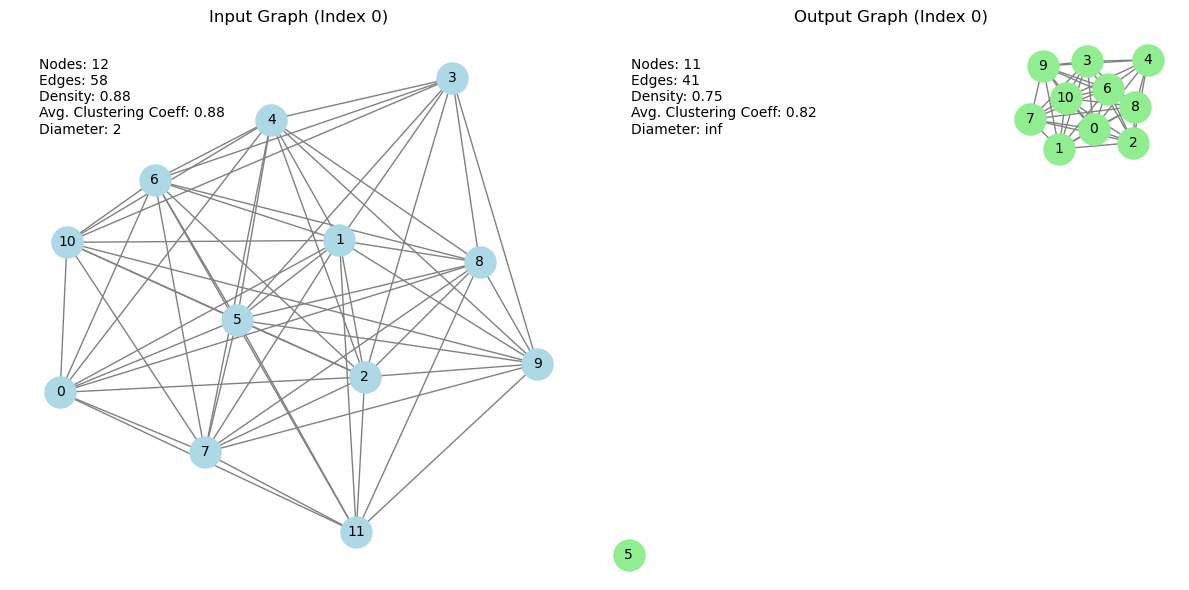

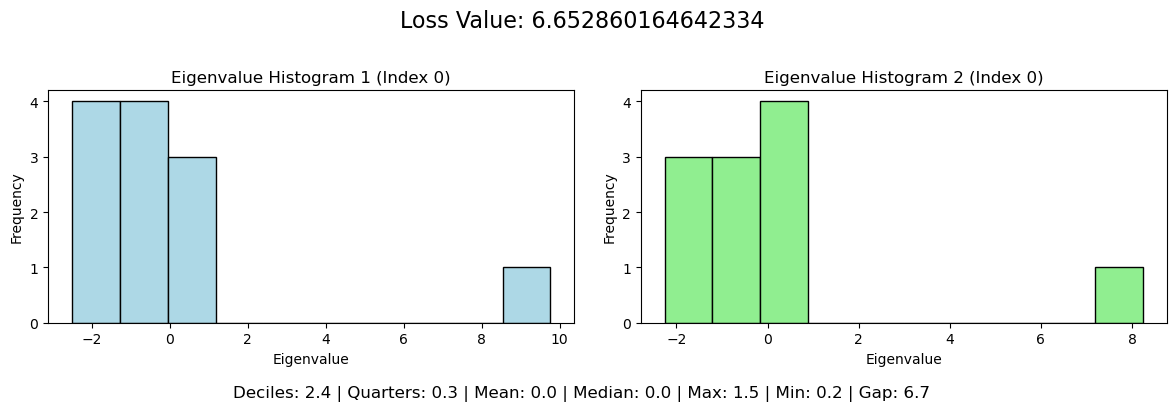

layer: 2 | erro 12.202070236206055


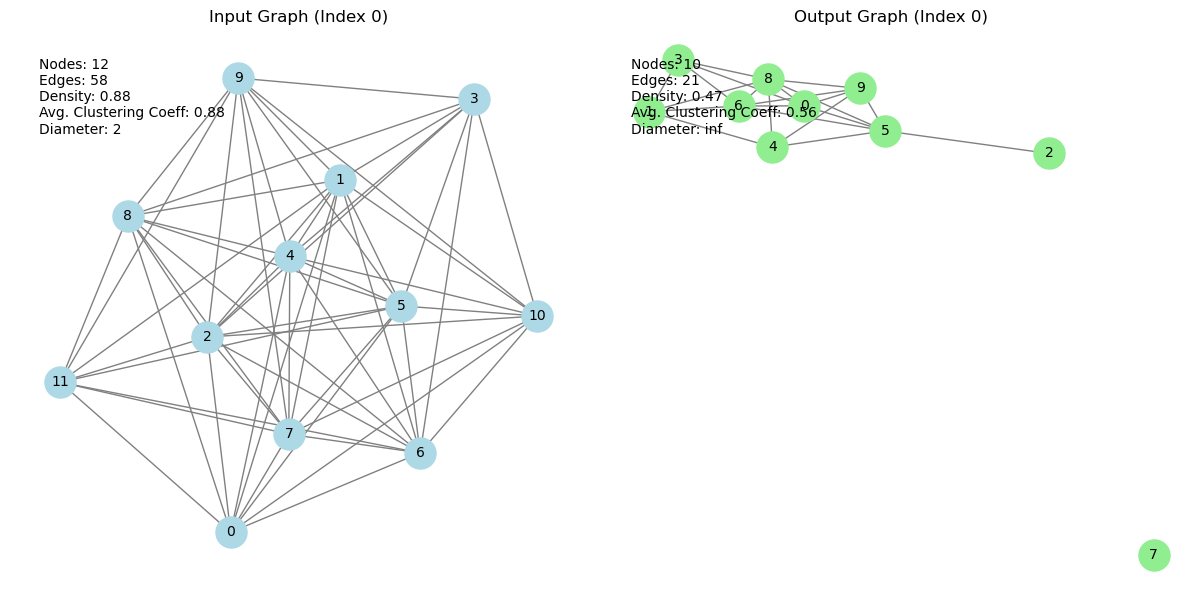

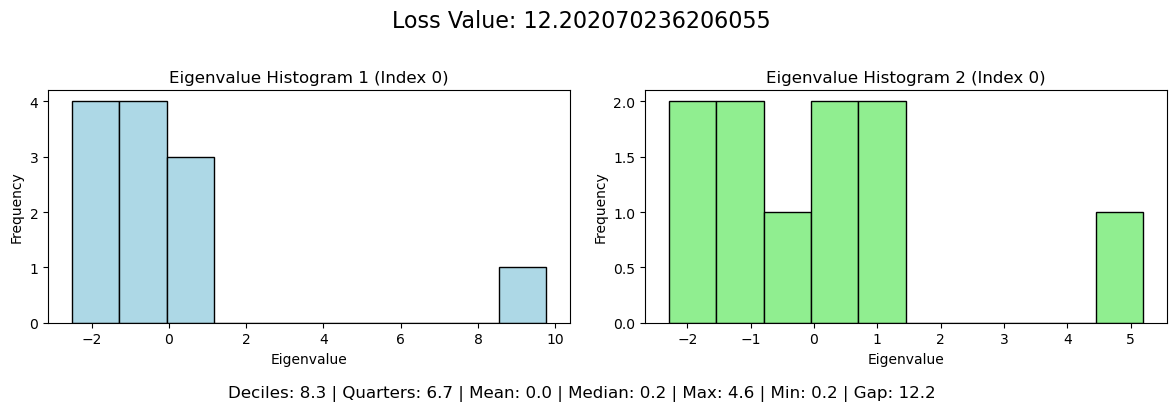

layer: 3 | erro 12.144868850708008


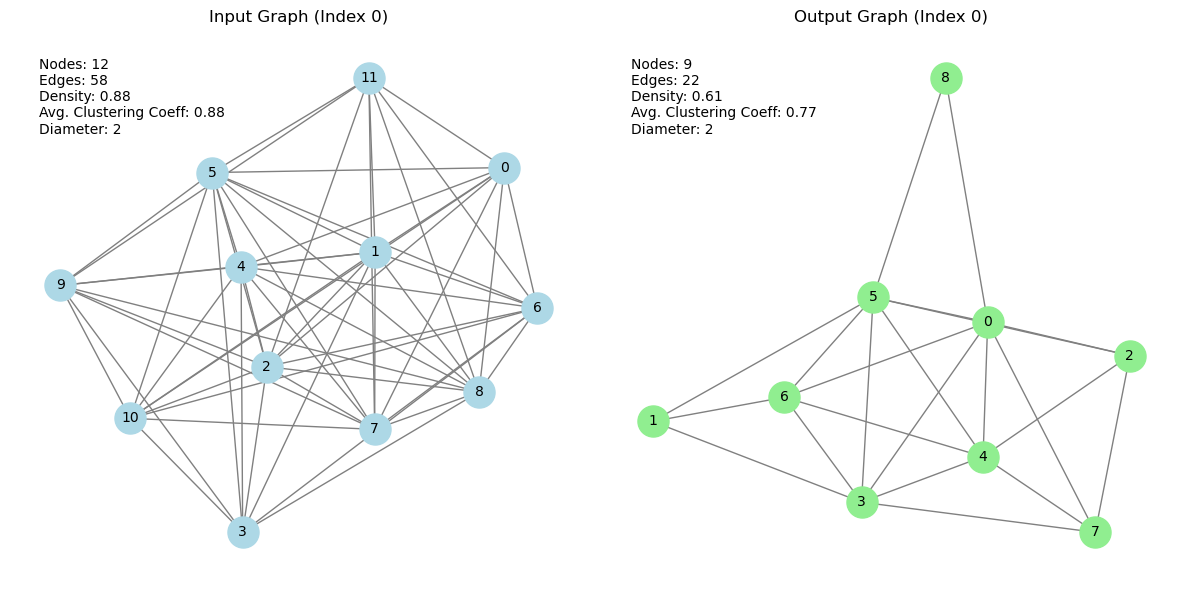

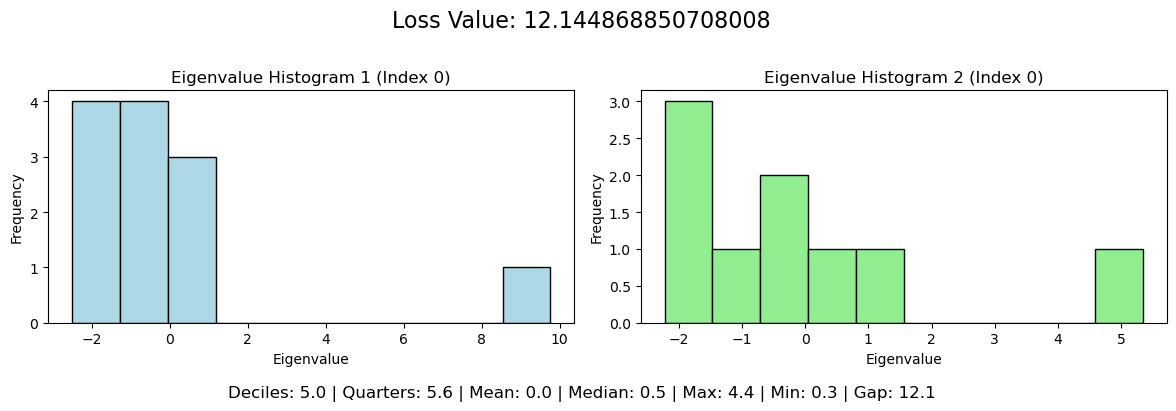

layer: 4 | erro 14.430619239807129


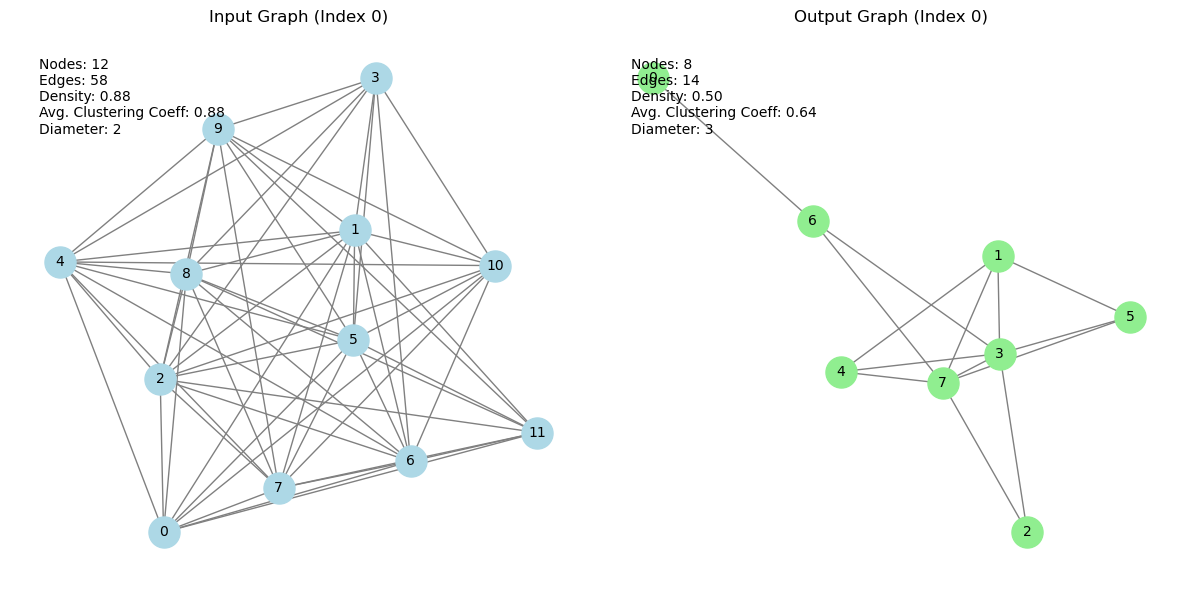

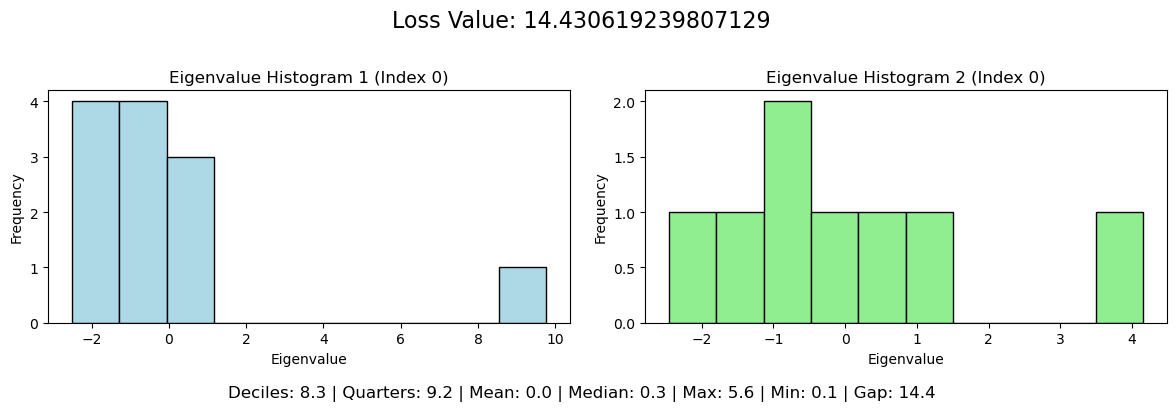

layer: 5 | erro 14.48758316040039


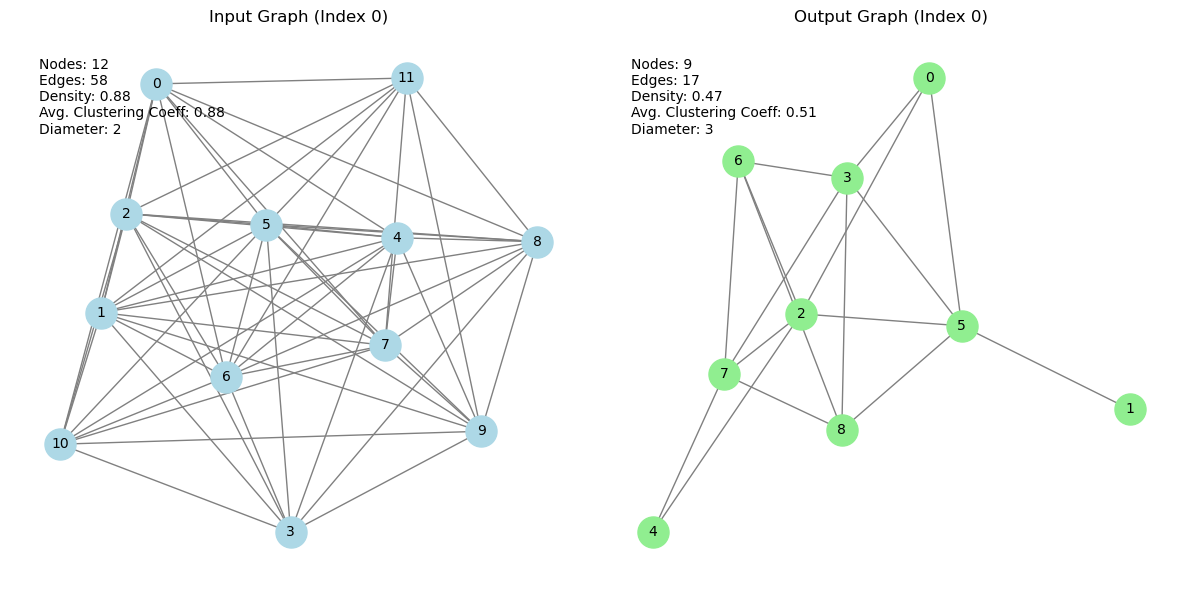

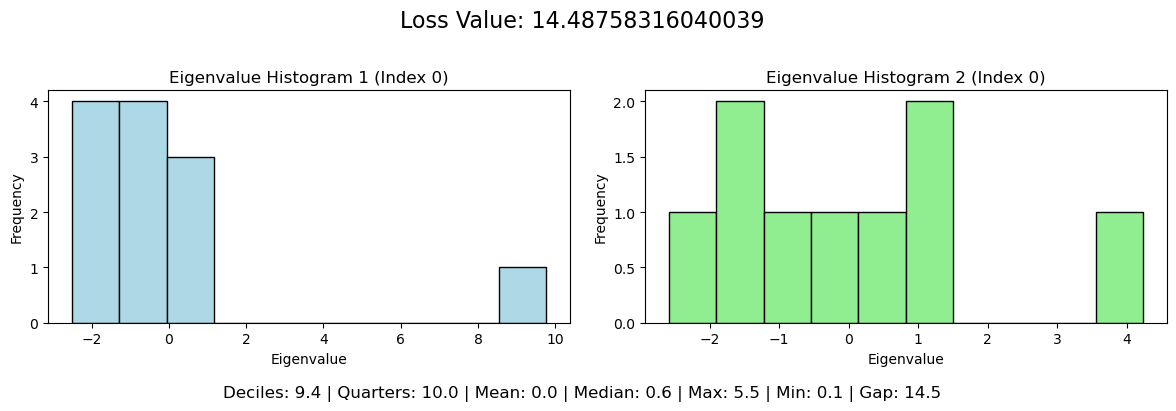

layer: 6 | erro 16.03394317626953


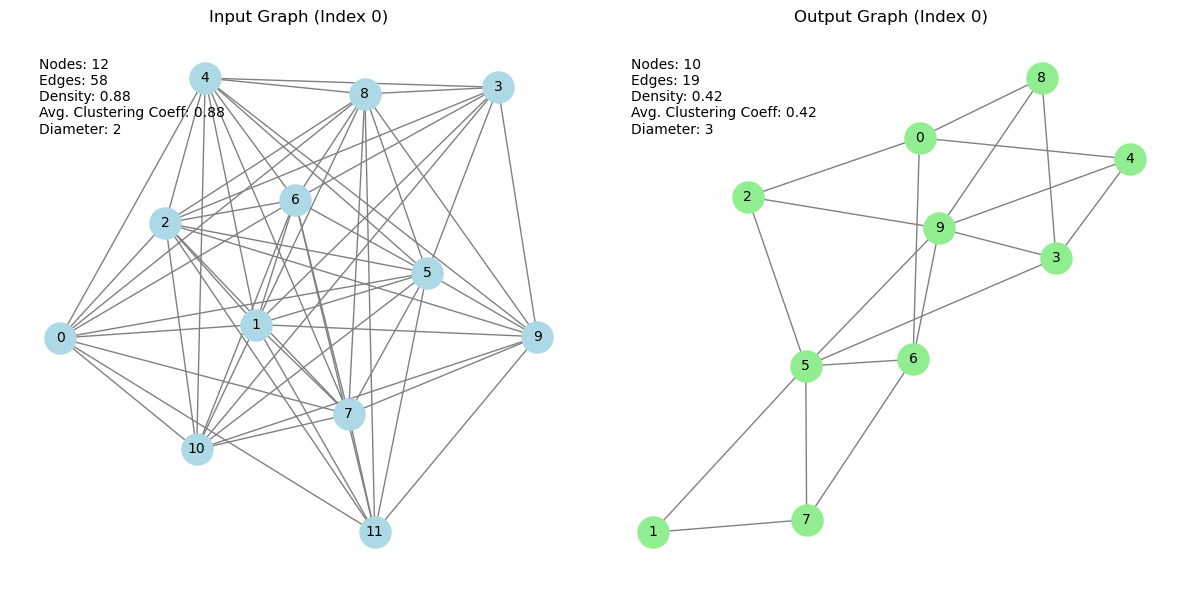

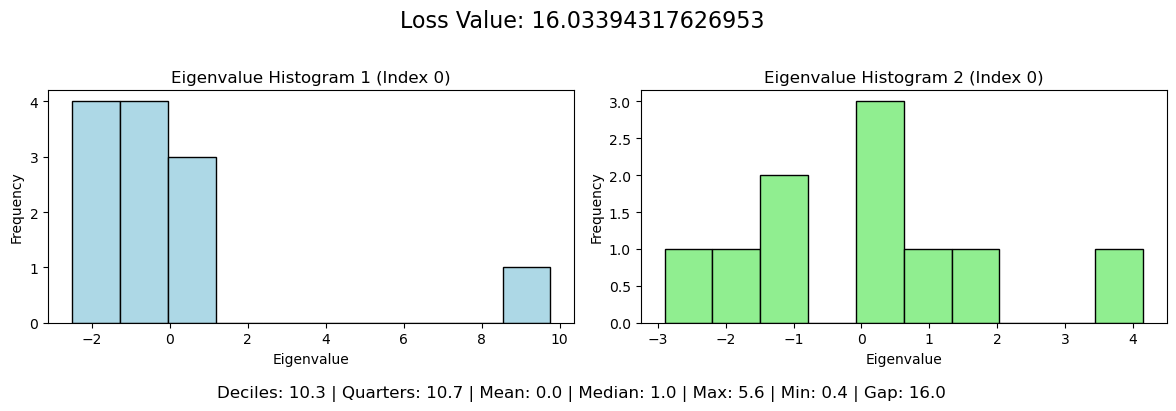

layer: 7 | erro 15.641144752502441


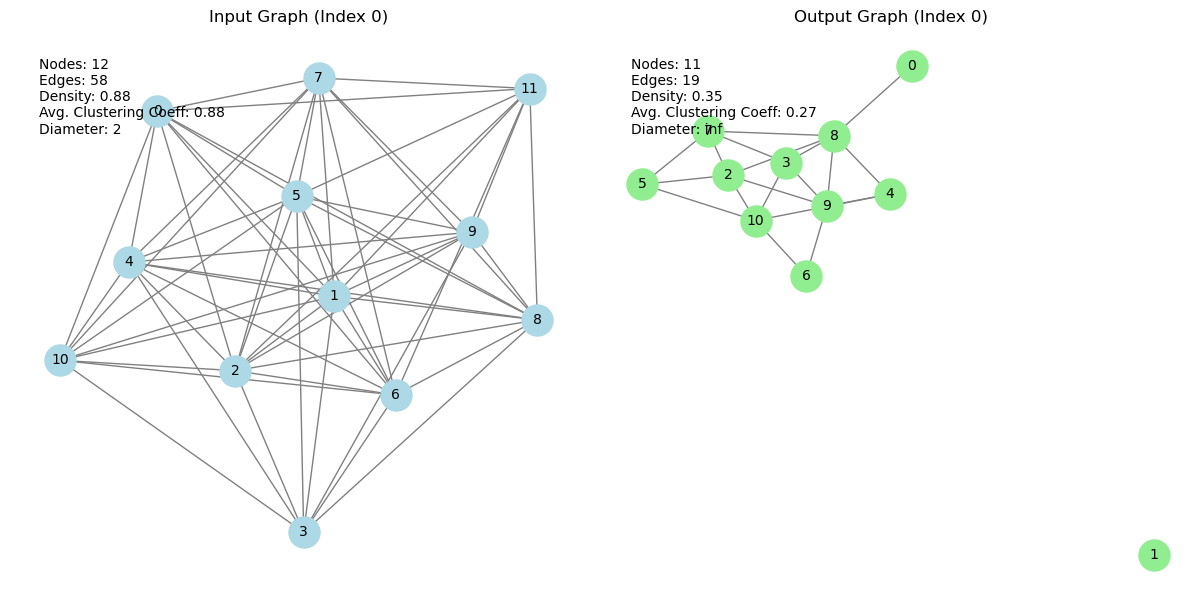

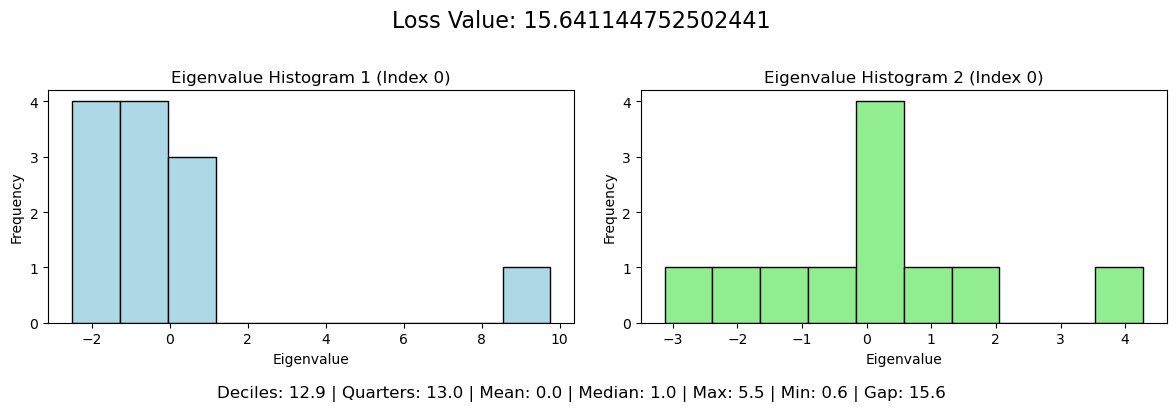

layer: 8 | erro 13.118125915527344


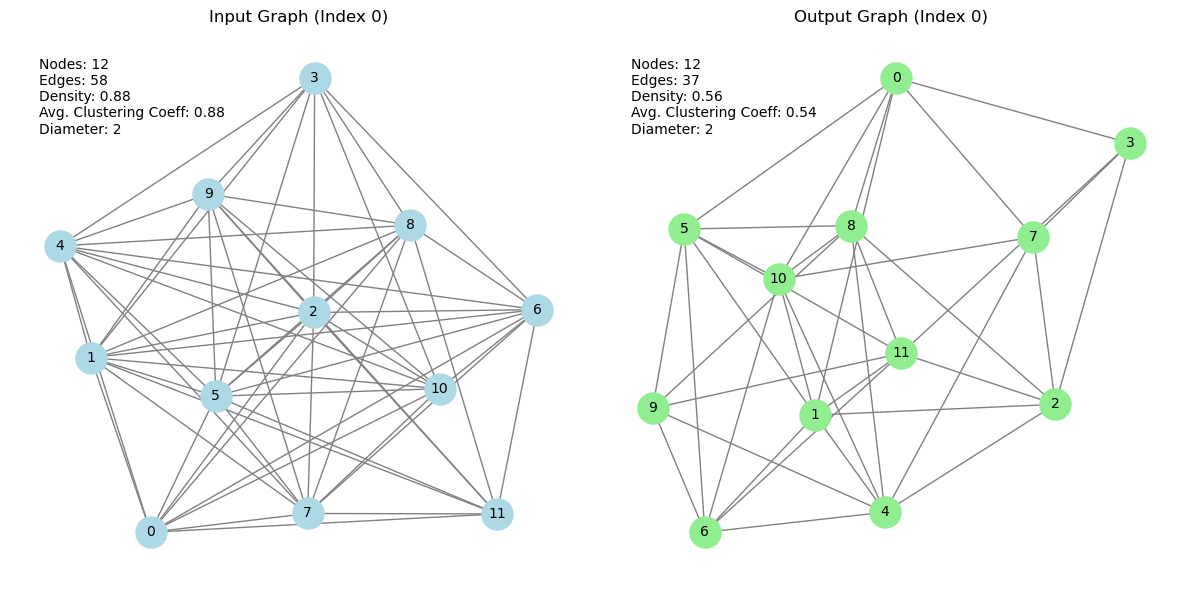

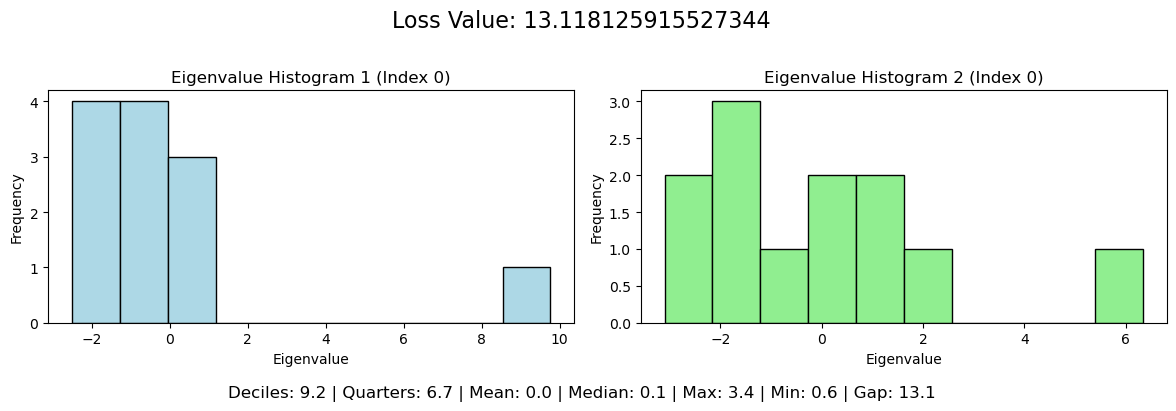


erro_layer_1  - Max: 22.3 | Mean: 8.8  | Min: 3.7 
erro_layer_2  - Max: 22.1 | Mean: 9.8  | Min: 3.8     
erro_layer_3  - Max: 24.6 | Mean: 10.7  | Min: 4.2   
erro_layer_4  - Max: 25.6 | Mean: 11.4  | Min: 4.6      
erro_layer_5  - Max: 25.3 | Mean: 11.1  | Min: 3.7      
erro_layer_6  - Max: 25.3 | Mean: 10.9  | Min: 3.3      
erro_layer_7  - Max: 26.9 | Mean: 10.6  | Min: 3.5  
erro_layer_8  - Max: 27.6 | Mean: 10.4  | Min: 1.6  
Epoch [1/40], Loss: 3.7675


In [23]:
#ENCODER layers

# Convert DataFrame to PyTorch tensor
adjacency_tensors = torch.tensor(df['lower_triangular'], dtype=torch.float32, requires_grad=True)

qtd_linhas = len(df)

# Create autoencoder instance
autoencoder_layers = Autoencoder_layers()

# Define loss function with custom loss
criterion_layers = CustomEMDLoss()

# Define optimizer
optimizer_layers = torch.optim.Adam(autoencoder_layers.parameters())

# Load the checkpoint
checkpoint = torch.load('new_checkpoint.pth')

# Restore the model state dictionary
autoencoder_layers.load_state_dict(checkpoint['model_state_dict'])

# Restore the optimizer state dictionary
optimizer_layers.load_state_dict(checkpoint['optimizer_state_dict'])

# If you want to resume training, set the model to training mode
#autoencoder_layers.train()

# If you want to evaluate the model, set it to evaluation mode
autoencoder_layers.eval()

# Train autoencoder layers
for epoch in range(1):
    optimizer_layers.zero_grad()

    outputs = autoencoder_layers(adjacency_tensors)
    if epoch % 10 == 0:
        #print(outputs[0])
        pass #print(outputs[0].shape)

    loss_layers = criterion_layers(adjacency_tensors, outputs)
   
    loss_layers.backward()
    optimizer_layers.step()
    print(f'Epoch [{epoch+1}/40], Loss: {loss_layers.item():.4f}')

In [112]:
import torch
import torch.nn as nn

class Encoder_128_96_64(nn.Module):
    def __init__(self):
        super(Encoder_128_96_64, self).__init__()
        self.layer1 = nn.Linear(8128, 4560)
        self.layer2 = nn.Linear(4560, 3655)


    def forward(self, x):
        a = self.layer1(x)
        out1 = torch.sigmoid(a)
        out2 = torch.sigmoid(self.layer2(out1))
        #out3 = self.layer3(out2)
        #out3 = torch.sigmoid(self.layer3(out2))
        #out3 = torch.where((self.layer3(out2)) > 0.5, 1., 0.)
        return out2 
'''
class Decoder_mini(nn.Module):
    def __init__(self):
        super(Decoder_mini, self).__init__()
        #self.layer1 = nn.Linear(32*32, 64*64)
        self.layer2 = nn.Linear(64*64, 128*128)

    def forward(self, x):
        out1 = torch.relu(self.layer2(x))
        #out2 = torch.relu(self.layer2(out1))
        return out1 #, out2
'''
class Autoencoder_128_96_64(nn.Module):
    def __init__(self):
        super(Autoencoder_128_96_64, self).__init__()
        self.encoder = Encoder_128_96_64()
        #self.decoder = Decoder_mini()

    def forward(self, x):
        encoded1 = self.encoder(x)
        #decoded1 = self.decoder(encoded1)
        
        return  encoded1


In [113]:
#ENCODER 24_12

# Convert DataFrame to PyTorch tensor
adjacency_tensors = torch.tensor(df['lower_triangular'], dtype=torch.float32, requires_grad=True)

qtd_linhas = len(df)

# Create autoencoder instance
autoencoder_128_96_64 = Autoencoder_128_96_64()

# Define loss function with custom loss
criterion_128_96_64 = CustomMSELoss()

# Define optimizer
optimizer_128_96_64 = torch.optim.Adam(autoencoder_128_96_64.parameters())

# Train autoencoder 24_12
for epoch in range(30):
    optimizer_128_96_64.zero_grad()

    outputs = autoencoder_128_96_64(adjacency_tensors)
    #print(outputs[0])

    loss_128_96_64 = criterion_128_96_64(adjacency_tensors, outputs)
   
    loss_128_96_64.backward()
    optimizer_128_96_64.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss_128_96_64.item():.4f}')

Epoch [1/10], Loss: 48.0059
Epoch [2/10], Loss: 67.0175
Epoch [3/10], Loss: 64.5966
Epoch [4/10], Loss: 49.0630
Epoch [5/10], Loss: 44.0978
Epoch [6/10], Loss: 40.8581
Epoch [7/10], Loss: 39.5397
Epoch [8/10], Loss: 39.7080
Epoch [9/10], Loss: 39.6474
Epoch [10/10], Loss: 39.5490
Epoch [11/10], Loss: 39.4970
Epoch [12/10], Loss: 39.4391
Epoch [13/10], Loss: 39.3824
Epoch [14/10], Loss: 39.3612
Epoch [15/10], Loss: 39.1898
Epoch [16/10], Loss: 39.2273
Epoch [17/10], Loss: 39.1378
Epoch [18/10], Loss: 39.0391
Epoch [19/10], Loss: 38.9266
Epoch [20/10], Loss: 38.8286
Epoch [21/10], Loss: 38.7646
Epoch [22/10], Loss: 38.5823
Epoch [23/10], Loss: 38.3825
Epoch [24/10], Loss: 38.2108
Epoch [25/10], Loss: 38.0692
Epoch [26/10], Loss: 37.8101
Epoch [27/10], Loss: 37.5963
Epoch [28/10], Loss: 37.3030
Epoch [29/10], Loss: 36.9927
Epoch [30/10], Loss: 36.6775


In [71]:
import torch
import torch.nn as nn

class Encoder_24_12(nn.Module):
    def __init__(self):
        super(Encoder_24_12, self).__init__()
        self.layer1 = nn.Linear(276, 190)
        self.layer2 = nn.Linear(190, 120)
        self.layer3 = nn.Linear(120, 66)

    def forward(self, x):
        a = self.layer1(x)
        out1 = torch.sigmoid(a)
        out2 = torch.sigmoid(self.layer2(out1))
        #out3 = self.layer3(out2)
        out3 = torch.sigmoid(self.layer3(out2))
        #out3 = torch.where((self.layer3(out2)) > 0.5, 1., 0.)
        return out3 
'''
class Decoder_mini(nn.Module):
    def __init__(self):
        super(Decoder_mini, self).__init__()
        #self.layer1 = nn.Linear(32*32, 64*64)
        self.layer2 = nn.Linear(64*64, 128*128)

    def forward(self, x):
        out1 = torch.relu(self.layer2(x))
        #out2 = torch.relu(self.layer2(out1))
        return out1 #, out2
'''
class Autoencoder_24_12(nn.Module):
    def __init__(self):
        super(Autoencoder_24_12, self).__init__()
        self.encoder = Encoder_24_12()
        #self.decoder = Decoder_mini()

    def forward(self, x):
        encoded1 = self.encoder(x)
        #decoded1 = self.decoder(encoded1)
        
        return  encoded1


In [72]:
#ENCODER 24_12

# Convert DataFrame to PyTorch tensors
num_nodes_inicial = 24

adjacency_tensors = torch.tensor(df['lower_triangular'], dtype=torch.float32, requires_grad=True)

qtd_linhas = len(df)

# Create autoencoder instance
autoencoder_24_12 = Autoencoder_24_12()

# Define loss function with custom loss
criterion_24_12 = CustomMSELoss()

# Define optimizer
optimizer_24_12 = torch.optim.Adam(autoencoder_24_12.parameters())

# Train autoencoder 24_12
for epoch in range(100):
    optimizer_24_12.zero_grad()

    outputs = autoencoder_24_12(adjacency_tensors)
    #print(outputs[0])

    loss_24_12 = criterion_24_12(adjacency_tensors, outputs)
   
    loss_24_12.backward()
    optimizer_24_12.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss_24_12.item():.4f}')

Epoch [1/10], Loss: 18.6934
Epoch [2/10], Loss: 18.4838
Epoch [3/10], Loss: 18.2916
Epoch [4/10], Loss: 18.0933
Epoch [5/10], Loss: 17.8902
Epoch [6/10], Loss: 17.6824
Epoch [7/10], Loss: 14.8874
Epoch [8/10], Loss: 12.0897
Epoch [9/10], Loss: 12.6238
Epoch [10/10], Loss: 15.0744
Epoch [11/10], Loss: 15.9430
Epoch [12/10], Loss: 17.4272
Epoch [13/10], Loss: 17.2618
Epoch [14/10], Loss: 17.1303
Epoch [15/10], Loss: 17.0200
Epoch [16/10], Loss: 16.9504
Epoch [17/10], Loss: 16.8867
Epoch [18/10], Loss: 16.8386
Epoch [19/10], Loss: 16.8417
Epoch [20/10], Loss: 16.8595
Epoch [21/10], Loss: 16.8717
Epoch [22/10], Loss: 16.8888
Epoch [23/10], Loss: 16.9057
Epoch [24/10], Loss: 16.9110
Epoch [25/10], Loss: 16.9067
Epoch [26/10], Loss: 16.8949
Epoch [27/10], Loss: 16.8768
Epoch [28/10], Loss: 16.8515
Epoch [29/10], Loss: 16.8202
Epoch [30/10], Loss: 16.7923
Epoch [31/10], Loss: 16.7721
Epoch [32/10], Loss: 16.7515
Epoch [33/10], Loss: 16.7305
Epoch [34/10], Loss: 16.7090
Epoch [35/10], Loss: 16

In [83]:
import torch

def lower_triangular_only(tensor):
    # Get the number of matrices and the size of each matrix
    num_matrices, matrix_size, _ = tensor.size()

    # Calculate the number of elements in the lower triangular part (excluding the diagonal)
    num_elements_lower_triangular = (matrix_size * (matrix_size - 1)) // 2

    # Create an empty tensor to store the lower triangular elements
    lower_triangular_tensor = torch.zeros(num_matrices, num_elements_lower_triangular)

    # Iterate over each matrix
    for i in range(num_matrices):
        # Flatten the lower triangular part of the matrix (excluding the diagonal)
        lower_triangular_tensor[i] = tensor[i].tril(diagonal=-1)[torch.tril(torch.ones(matrix_size, matrix_size), diagonal=-1).bool()].flatten()

    return lower_triangular_tensor

# Example usage:
# Create a tensor with two adjacency matrices
adjacency_matrices = torch.tensor([[[1, 2, 3, 4],
                                    [15, 5, 6, 7],
                                    [9, 0, 8, 9],
                                    [8, 7, 0, 10]],
                                   [[9, 8, 7, 6],
                                    [0, 5, 4, 3],
                                    [0, 0, 2, 1],
                                    [1, 3, 2, 0]]])

# Get the lower triangular part of the matrices (excluding the diagonal)
lower_triangular_result = lower_triangular_only(adjacency_matrices)

print(lower_triangular_result)


tensor([[15.,  9.,  0.,  8.,  7.,  0.],
        [ 0.,  0.,  0.,  1.,  3.,  2.]])


In [107]:
teste = torch.tensor([[[0., 8., 9., 8.],
         [8., 0., 0., 7.],
         [9., 0., 0., 0.],
         [8., 7., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 0., 3.],
         [0., 0., 0., 2.],
         [1., 3., 2., 0.]]])

lower_triangular_result = lower_triangular_only(teste)

print(lower_triangular_result)

tensor([[8., 9., 0., 8., 7., 0.],
        [0., 0., 0., 1., 3., 2.]])


In [108]:
import torch

def from_one_dimension_representation(lower_triangular_tensor):
    # Get the number of matrices and the size of each matrix
    num_matrices, num_elements_lower_triangular = lower_triangular_tensor.size()

    # Calculate the size of the square matrix based on the number of elements in the lower triangular tensor
    matrix_size = int((2 * num_elements_lower_triangular + 0.25)**0.5 - 0.5) + 1

    # Create an empty tensor to store the adjacency matrices
    adjacency_matrices = torch.zeros(num_matrices, matrix_size, matrix_size)

    # Iterate over each matrix
    for i in range(num_matrices):
        # Create a tensor with zeros
        matrix = torch.zeros(matrix_size, matrix_size)

        # Iterate over the indices of the mask and assign values from the lower triangular tensor
        idx = 0
        for row in range(1, matrix_size):
            for col in range(matrix_size):
                if row > col:
                    matrix[row, col] = lower_triangular_tensor[i, idx]
                    idx += 1

        # Fill the upper triangular part (excluding the diagonal) by transposing the lower triangular part
        matrix += matrix.clone().t()

        # Store the adjacency matrix
        adjacency_matrices[i] = matrix

    return adjacency_matrices

# Example usage:
# Create a tensor with the lower triangular part of two adjacency matrices
lower_triangular_tensor = torch.tensor([[8., 9., 0., 8., 7., 0.],
                                        [0., 0., 0., 1., 3., 2.]])

# Convert the lower triangular tensor to adjacency matrices
adjacency_matrices = from_one_dimension_representation(lower_triangular_result)

print(adjacency_matrices)


tensor([[[0., 8., 9., 8.],
         [8., 0., 0., 7.],
         [9., 0., 0., 0.],
         [8., 7., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 0., 3.],
         [0., 0., 0., 2.],
         [1., 3., 2., 0.]]])


In [53]:
print(outputs[0].view(12, 12))

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.]])


In [50]:
print(adjacency_tensors[0])

tensor([[0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
         0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
         1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
         0., 1., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
         1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,

In [36]:
import torch
import torch.nn as nn
   
class Encoder_128_112_96(nn.Module):
    def __init__(self):
        super(Encoder_128_112_96, self).__init__()
        self.layer1 = nn.Linear(128*128, 112*112)
        self.layer2 = nn.Linear(112*112, 96*96)

    def forward(self, x):
        a = self.layer1(x)
        out1 = torch.sigmoid(a)
        out2 = torch.sigmoid(self.layer2(out1))
        return out2
'''
class Decoder_mini(nn.Module):
    def __init__(self):
        super(Decoder_mini, self).__init__()
        #self.layer1 = nn.Linear(32*32, 64*64)
        self.layer2 = nn.Linear(64*64, 128*128)

    def forward(self, x):
        out1 = torch.relu(self.layer2(x))
        #out2 = torch.relu(self.layer2(out1))
        return out1 #, out2
'''
class Autoencoder_128_112_96(nn.Module):
    def __init__(self):
        super(Autoencoder_128_112_96, self).__init__()
        self.encoder = Encoder_128_112_96()
        #self.decoder = Decoder_mini()

    def forward(self, x):
        encoded1 = self.encoder(x)
        #decoded1 = self.decoder(encoded1)
        
        return  encoded1


In [ ]:
#ENCODER 128_112_96

# Convert DataFrame to PyTorch tensors
num_nodes_inicial = 128

adjacency_tensors = torch.tensor(df['padded_Matrix_A'], dtype=torch.float32, requires_grad=True)

qtd_linhas = len(df)

# Create autoencoder instance
autoencoder_128_112_96 = Autoencoder_128_112_96()

# Define loss function with custom loss
criterion_128_112_96 = CustomMSELoss()

# Define optimizer
optimizer_128_112_96 = torch.optim.Adam(autoencoder_128_112_96.parameters())

# Train autoencoder 128_96
for epoch in range(30):
    optimizer_128_112_96.zero_grad()

    outputs = autoencoder_128_112_96(adjacency_tensors.view(qtd_linhas, num_nodes_inicial*num_nodes_inicial))

    loss_128_112_96 = criterion_128_112_96(adjacency_tensors, outputs)
   
    loss_128_112_96.backward()
    optimizer_128_112_96.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss_128_112_96.item():.4f}')

Maior Erro: 81.86388397216797
Menor Erro: 15.011547088623047
Epoch [1/10], Loss: 47.1406
Maior Erro: 116.42889404296875
Menor Erro: 39.4102783203125
Epoch [2/10], Loss: 72.4575
Maior Erro: 113.99850463867188
Menor Erro: 39.056766510009766
Epoch [3/10], Loss: 71.3056
Maior Erro: 113.21031951904297
Menor Erro: 38.324012756347656
Epoch [4/10], Loss: 70.8463
Maior Erro: 112.83367919921875
Menor Erro: 38.23379898071289
Epoch [5/10], Loss: 70.6294
Maior Erro: 112.72103118896484
Menor Erro: 38.12103271484375
Epoch [6/10], Loss: 70.5165
Maior Erro: 112.71829223632812
Menor Erro: 38.04468536376953
Epoch [7/10], Loss: 70.4651
Maior Erro: 112.6906509399414
Menor Erro: 38.02104187011719
Epoch [8/10], Loss: 70.4376
Maior Erro: 112.62906646728516
Menor Erro: 38.00749206542969
Epoch [9/10], Loss: 70.3990
Maior Erro: 112.58042907714844
Menor Erro: 37.98046875
Epoch [10/10], Loss: 70.3655
Maior Erro: 112.55955505371094
Menor Erro: 37.9595947265625
Epoch [11/10], Loss: 70.3548
Maior Erro: 112.5617904663